In [55]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [58]:
df = pd.read_csv('https://raw.githubusercontent.com/getdatachimp/demo/main/prep/borked_iris.csv')
df

Unnamed: 0  sepal_length  sepal_width  petal_length  petal_width  \
0             0           5.1          3.5           1.4          0.2   
1             1           4.9          3.0           1.4          0.2   
2             2           4.7          3.2           1.3          0.2   
3             3           4.6          3.1           1.5          0.2   
4             4           5.0          3.6           1.4          0.2   
..          ...           ...          ...           ...          ...   
145         145           6.7          3.0           5.2          2.3   
146         146           6.3          2.5           5.0          1.9   
147         147           6.5          3.0           5.2          2.0   
148         148           6.2          3.4           5.4          2.3   
149         149           5.9          3.0           5.1          1.8   

       variety collector  
0       Setosa       Sam  
1       Setosa       Sam  
2       Setosa       Sam  
3       Setosa       Sam  
4       Setosa       Sam  
..         ...       ...  
145  Virginica       Sam  
146  Virginica       Sam  
147  Virginica       Sam  
148  Virginica       Sam  
149  Virginica       Sam  

[150 rows x 7 columns]

<AxesSubplot: xlabel='sepal_length', ylabel='petal_length'>

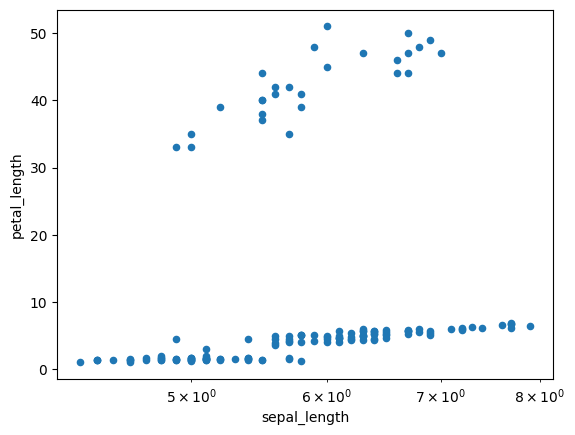

In [17]:
df.plot.scatter(x='sepal_length', y='petal_length', logx=True)

In [32]:
from IPython.core.display import HTML
HTML?

Init signature: HTML(data=None, url=None, filename=None, metadata=None)
Docstring:      Validate that display data is text
Init docstring:
Create a display object given raw data.

When this object is returned by an expression or passed to the
display function, it will result in the data being displayed
in the frontend. The MIME type of the data should match the
subclasses used, so the Png subclass should be used for 'image/png'
data. If the data is a URL, the data will first be downloaded
and then displayed. If

Parameters
----------
data : unicode, str or bytes
    The raw data or a URL or file to load the data from
url : unicode
    A URL to download the data from.
filename : unicode
    Path to a local file to load the data from.
metadata : dict
    Dict of metadata associated to be the object when displayed
File:           ~/.pyenv/versions/3.11.1/lib/python3.11/site-packages/IPython/core/display.py
Type:           type
Subclasses:     


In [53]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df['variety'].map({'Setosa': 0, 'Versicolor': 1, 'Virginica': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

NameError: name 'df' is not defined

In [3]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression()
)

model = pipeline.fit(X_train, y_train)

In [4]:
model.score(X_test, y_test)

0.7368421052631579

In [5]:
from doubtlab.ensemble import DoubtEnsemble
from doubtlab.reason import ProbaReason, WrongPredictionReason
reasons = {
    'proba': ProbaReason(model=model),
    'wrong_pred': WrongPredictionReason(model=model)
}

# Pass these reasons to a doubtlab instance.
doubt = DoubtEnsemble(**reasons)

# Get the ordered indices of examples worth checking again
indices = doubt.get_indices(X_train, y_train)
# Get dataframe with "reason"-ing behind the sorting
predicates = doubt.get_predicates(X_train, y_train)

In [6]:
df = df.join(predicates).drop(['Unnamed: 0'], axis=1)
df.iloc[predicates.index].head(len(indices))

sepal_length  sepal_width  petal_length  petal_width     variety  \
99            5.7          2.8           4.1          1.3  Versicolor   
55            5.7          2.8           4.5          1.3  Versicolor   
92            5.8          2.6           4.0          1.2  Versicolor   
41            4.5          2.3           1.3          0.3      Setosa   
96            5.7          2.9           4.2          1.3  Versicolor   
68            6.2          2.2           4.5          1.5  Versicolor   
64            5.6          2.9           3.6          1.3  Versicolor   
61            5.9          3.0           4.2          1.5  Versicolor   
106           4.9          2.5           4.5          1.7   Virginica   
87            6.3          2.3           4.4          1.3  Versicolor   
142           5.8          2.7           5.1          1.9   Virginica   
72            6.3          2.5           4.9          1.5  Versicolor   
74            6.4          2.9           4.3          1.3  Versicolor   
91            6.1          3.0           4.6          1.4  Versicolor   
101           5.8          2.7           5.1          1.9   Virginica   
113           5.7          2.5           5.0          2.0   Virginica   
119           6.0          2.2           5.0          1.5   Virginica   

    collector  predicate_proba  predicate_wrong_pred  
99       Eric              1.0                   1.0  
55       Eric              1.0                   1.0  
92       Eric              1.0                   1.0  
41        Sam              1.0                   1.0  
96       Eric              1.0                   1.0  
68       Eric              1.0                   1.0  
64       Eric              1.0                   1.0  
61       Eric              0.0                   1.0  
106       Sam              0.0                   1.0  
87       Eric              0.0                   1.0  
142       Sam              1.0                   0.0  
72       Eric              0.0                   1.0  
74       Eric              0.0                   1.0  
91       Eric              0.0                   1.0  
101       Sam              1.0                   0.0  
113       Sam              0.0                   1.0  
119       Sam              0.0                   1.0

Eric is always associated with doubtly doubtful predictions. What's up with that? Pairplot colored by collector could be helpful here.

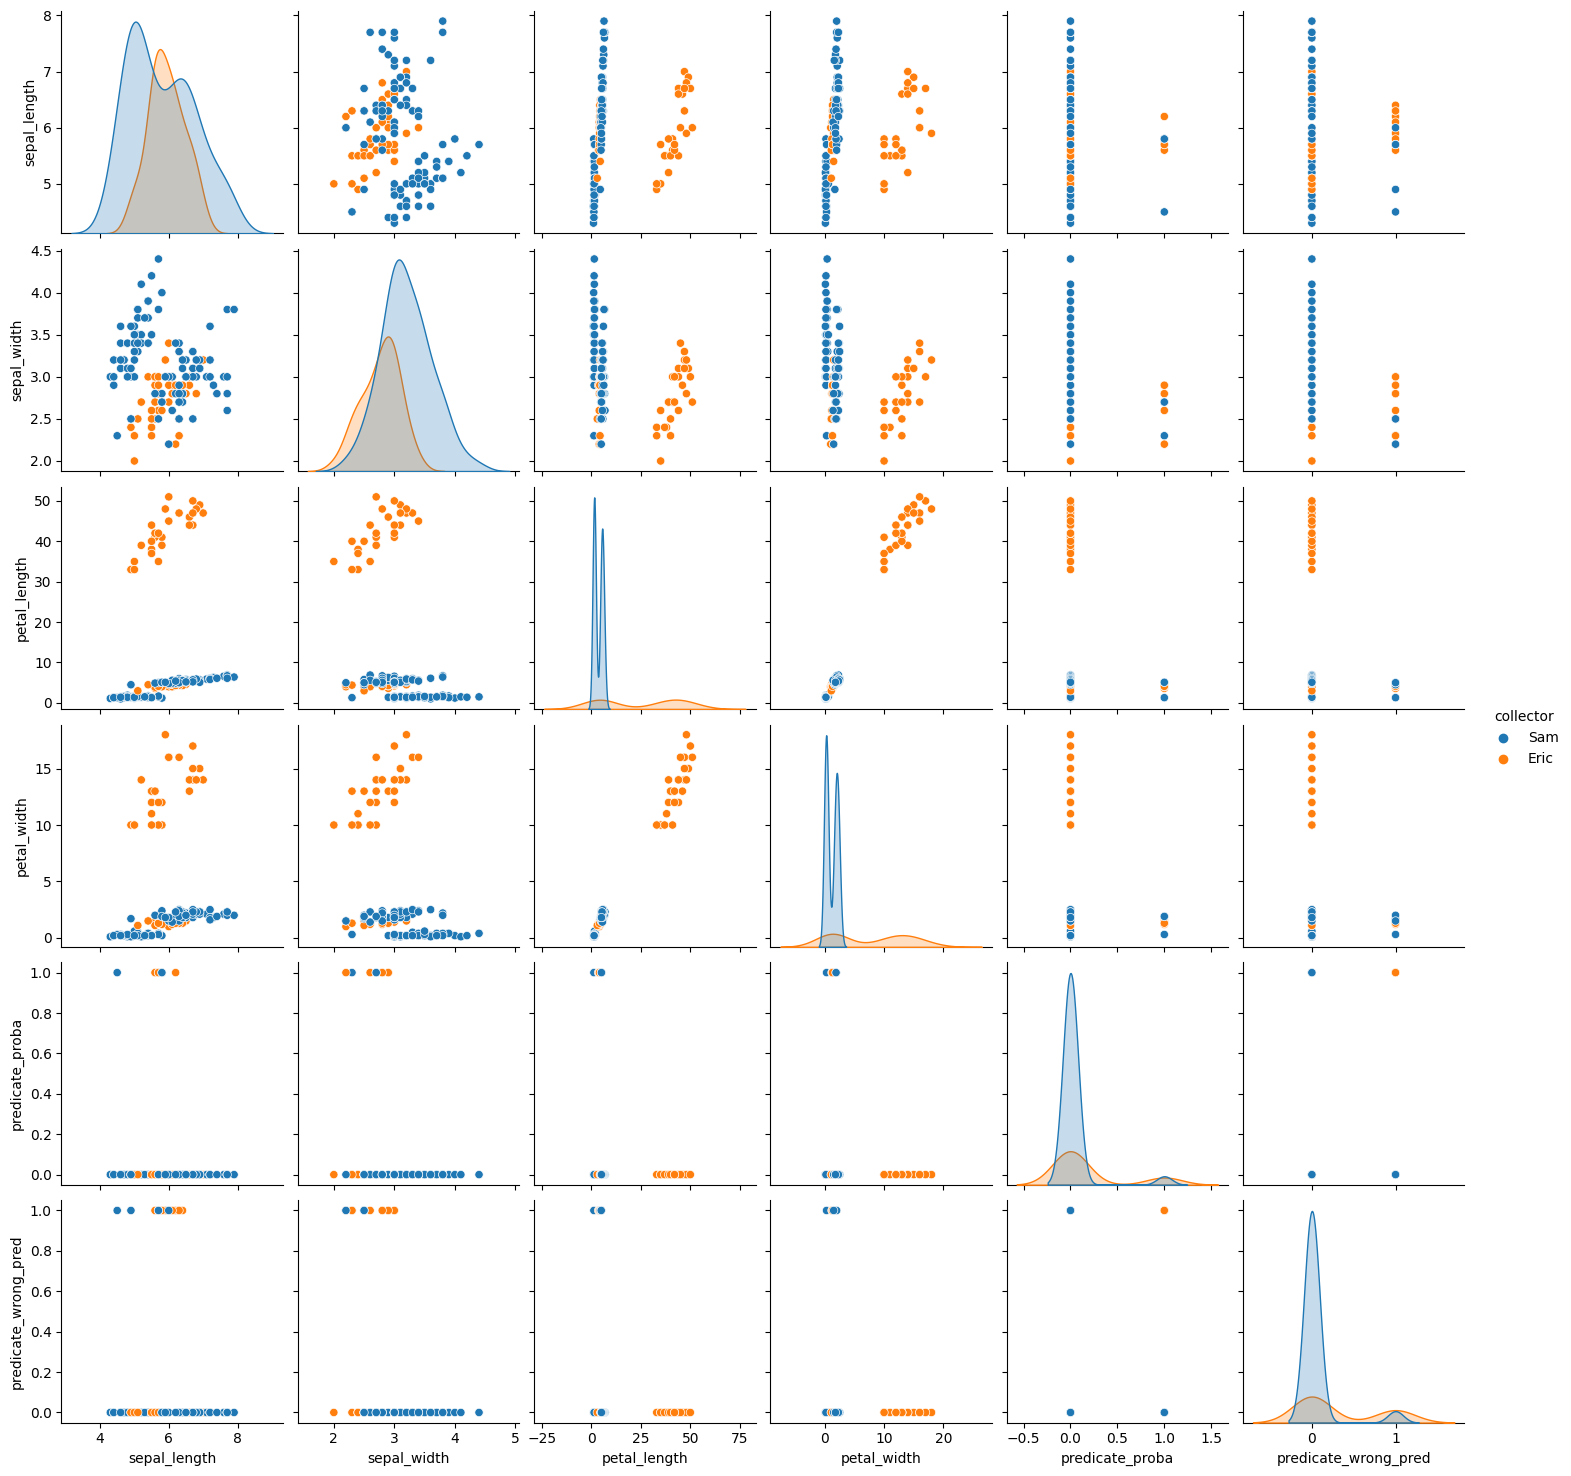

In [7]:
import seaborn as sns
sns.pairplot(data=df, hue='collector')

Notice how different the distributions are different by collector for petal_length and petal_width

In [ ]:
# Use pandera to create simple check that features >= some values
import pandera as pa

schema = pa.DataFrameSchema({
  'variety': pa.Column(str),
  'petal_length': pa.Column(float, [
    pa.Check(lambda g: g['Versicolor'].max() <= 30, groupby='variety'), 
    pa.Check(lambda g: g['Setosa'] <= 10, groupby='variety'),
    pa.Check(lambda g: g['Virginica'] <= 40, groupby='variety')
    ])
})

schema.validate(df)


In [9]:
df.loc[df['collector'] == 'Eric', 'petal_length'] /= 100
df.loc[df['collector'] == 'Eric', 'petal_width'] /= 100

In [20]:
schema.validate(df)

sepal_length  sepal_width  petal_length  petal_width    variety  \
0             5.1          3.5           1.4          0.2     Setosa   
1             4.9          3.0           1.4          0.2     Setosa   
2             4.7          3.2           1.3          0.2     Setosa   
3             4.6          3.1           1.5          0.2     Setosa   
4             5.0          3.6           1.4          0.2     Setosa   
..            ...          ...           ...          ...        ...   
145           6.7          3.0           5.2          2.3  Virginica   
146           6.3          2.5           5.0          1.9  Virginica   
147           6.5          3.0           5.2          2.0  Virginica   
148           6.2          3.4           5.4          2.3  Virginica   
149           5.9          3.0           5.1          1.8  Virginica   

    collector  predicate_proba  predicate_wrong_pred  
0         Sam              0.0                   0.0  
1         Sam              0.0                   0.0  
2         Sam              0.0                   0.0  
3         Sam              0.0                   0.0  
4         Sam              0.0                   0.0  
..        ...              ...                   ...  
145       Sam              0.0                   0.0  
146       Sam              0.0                   0.0  
147       Sam              0.0                   0.0  
148       Sam              0.0                   0.0  
149       Sam              0.0                   0.0  

[150 rows x 8 columns]

In [21]:
# If there's time, use pandera for hypothesis testing check for something more robust

In [50]:
#wat

In [2]:
%connect_info

{
  "shell_port": 9015,
  "iopub_port": 9017,
  "stdin_port": 9016,
  "control_port": 9009,
  "hb_port": 9008,
  "ip": "127.0.0.1",
  "key": "ea2768b1-44a5-4bc0-969d-aad92b25953c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-70813VEqxdz3fAqhr.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [47]:
# move to default.ipynb
import pandas as pd
min = pd.DataFrame(
    index=['Setosa', 'Versicolor', 'Virginica'], 
    data={
          'min_petal_length': [10, 30, 45],
          'min_petal_width': [1, 10, 14],
  })

result = (
    df[['variety', 'petal_length', 'petal_width']]
      .join(min, on='variety')
      .query('petal_length > min_petal_length | petal_width > min_petal_width')
)
result if not result.empty else None

variety  petal_length  petal_width  min_petal_length  min_petal_width
0       Setosa           1.4          0.2                10                1
1       Setosa           1.4          0.2                10                1
2       Setosa           1.3          0.2                10                1
3       Setosa           1.5          0.2                10                1
4       Setosa           1.4          0.2                10                1
..         ...           ...          ...               ...              ...
145  Virginica           5.2          2.3                45               14
146  Virginica           5.0          1.9                45               14
147  Virginica           5.2          2.0                45               14
148  Virginica           5.4          2.3                45               14
149  Virginica           5.1          1.8                45               14

[123 rows x 5 columns]

In [244]:
df.loc[df['collector'] == 'Eric', 'petal_length'] *= 100
df.loc[df['collector'] == 'Eric', 'petal_width'] *= 100

sepal_length  sepal_width  petal_length  petal_width    variety  \
0             5.1          3.5      1.400000     0.200000     Setosa   
1             4.9          3.0      0.033635     0.004805     Setosa   
2             4.7          3.2      1.300000     0.200000     Setosa   
3             4.6          3.1      0.036038     0.004805     Setosa   
4             5.0          3.6      0.033635     0.004805     Setosa   
..            ...          ...           ...          ...        ...   
145           6.7          3.0      0.124931     0.055258  Virginica   
146           6.3          2.5      5.000000     1.900000  Virginica   
147           6.5          3.0      5.200000     2.000000  Virginica   
148           6.2          3.4      0.129736     0.055258  Virginica   
149           5.9          3.0      5.100000     1.800000  Virginica   

    collector  predicate_proba  predicate_wrong_pred  
0         Sam              0.0                   0.0  
1        Eric              0.0                   0.0  
2         Sam              0.0                   0.0  
3        Eric              0.0                   0.0  
4        Eric              0.0                   0.0  
..        ...              ...                   ...  
145      Eric              0.0                   0.0  
146       Sam              0.0                   0.0  
147       Sam              0.0                   0.0  
148      Eric              1.0                   0.0  
149       Sam              0.0                   0.0  

[150 rows x 8 columns]

In [8]:
df

Unnamed: 0  sepal_length  sepal_width  petal_length  petal_width  \
0             0           5.1          3.5           1.4          0.2   
1             1           4.9          3.0           1.4          0.2   
2             2           4.7          3.2           1.3          0.2   
3             3           4.6          3.1           1.5          0.2   
4             4           5.0          3.6           1.4          0.2   
..          ...           ...          ...           ...          ...   
145         145           6.7          3.0           5.2          2.3   
146         146           6.3          2.5           5.0          1.9   
147         147           6.5          3.0           5.2          2.0   
148         148           6.2          3.4           5.4          2.3   
149         149           5.9          3.0           5.1          1.8   

       variety collector  
0       Setosa       Sam  
1       Setosa       Sam  
2       Setosa       Sam  
3       Setosa       Sam  
4       Setosa       Sam  
..         ...       ...  
145  Virginica       Sam  
146  Virginica       Sam  
147  Virginica       Sam  
148  Virginica       Sam  
149  Virginica       Sam  

[150 rows x 7 columns]

In [9]:
from deepchecks.tabular import Dataset
ds = Dataset(df)

from deepchecks.tabular.suites import data_integrity

# Run Suite:
integ_suite = data_integrity()
suite_result = integ_suite.run(ds)
# Note: the result can be saved as html using suite_result.save_as_html()
# or exported to json using suite_result.to_json()
suite_result.show()

Data Integrity Suite: 
 
 
 
 12/12 [Time: 00:00, Check=Identifier Label Correlation]

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_CD2BB4V2FTHTO84G3T27HUP2K">Data Integrity Sui…

In [11]:
from ipywidgets import interact

interact(lambda x: print(x), x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.<lambda>(x)>